In [2]:
import torch
from torch.utils.data import DataLoader , ConcatDataset , random_split
from torchvision import datasets, transforms


BATCH_SIZE = 64
IMG_SIZE = 96

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),       # aseguramos tamaño
    transforms.RandomHorizontalFlip(p=0.5),        # flip aleatorio
    transforms.RandomRotation(15),                 # rotación leve
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),              # variaciones de color
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])])

train_dataset = datasets.STL10(root="./data", split="train",download=True, transform=train_transform)
test_dataset = datasets.STL10(root="./data", split="test",download=True, transform=test_transform)

full_dataset = ConcatDataset([train_dataset, test_dataset])

train_size = 10_000
test_size = len(full_dataset) - train_size

train_dataset_union, test_dataset_union = random_split(full_dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset_union, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)

test_loader = DataLoader(test_dataset_union, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2, pin_memory=True)

print(f"Train set: {len(train_dataset_union)} imágenes")
print(f"Test set: {len(test_dataset_union)} imágenes")

images, labels = next(iter(train_loader))
print("Batch imágenes:", images.shape)  # (BATCH_SIZE, 3, 96, 96)
print("Batch labels:", labels.shape)


Train set: 10000 imágenes
Test set: 3000 imágenes
Batch imágenes: torch.Size([64, 3, 96, 96])
Batch labels: torch.Size([64])


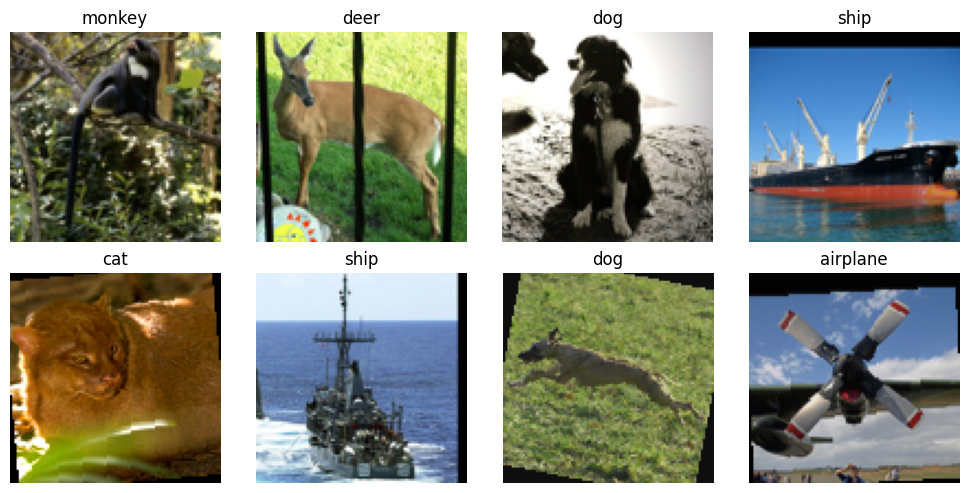

In [3]:
import matplotlib.pyplot as plt
import numpy as np

classes = ['airplane', 'bird', 'car', 'cat', 'deer',
           'dog', 'horse', 'monkey', 'ship', 'truck']

def denormalize(img_tensor):
    img = img_tensor.clone().detach()
    img = img * 0.5 + 0.5
    img = np.clip(img.numpy(), 0, 1)
    return img

images, labels = next(iter(train_loader))
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()

for i in range(8):
    img = denormalize(images[i]).transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].set_title(classes[labels[i]])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Model Blocks



In [4]:
import torch
import torch.nn as nn

class ConvBNReLU(nn.Module):
    """
    Bloque: Conv2d (bias=False) -> BatchNorm2d -> ReLU.
    Útil para 1x1/3x3/5x5 con el padding correcto.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding = 0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                      padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x: torch.Tensor):
        return self.net(x)

class InceptionV1Block(nn.Module):
    """
    Inception (GoogLeNet v1) canónico con 4 ramas en paralelo:
      - rama1: 1x1
      - rama2: 1x1 (reducción) -> 3x3
      - rama3: 1x1 (reducción) -> 5x5
      - rama4: 3x3 max-pool (stride=1, same) -> 1x1 (proyección)

    Parámetros (paper-like):
      in_channels:   canales de entrada al bloque
      out_1x1: #filtros de la rama 1 (1x1)
      red_3x3:  #filtros de reducción previa al 3x3
      out_3x3:  #filtros del 3x3
      red_5x5:   #filtros de reducción previa al 5x5
      out_5x5:  #filtros del 5x5
      pool_proj: #filtros de proyección 1x1 tras el max-pool

    Salida: concat canal (H y W se conservan).
    """
    def __init__(self,
        in_channels, out_1x1,
        red_3x3, out_3x3,
        red_5x5, out_5x5,
        pool_proj):

        super().__init__()

        # Rama 1: 1x1
        self.branch1 = ConvBNReLU(in_channels, out_1x1, kernel_size=1, padding=0)

        # Rama 2: 1x1 (reduce) -> 3x3 (same)
        self.branch2_reduce = ConvBNReLU(in_channels, red_3x3, kernel_size=1, padding=0)
        self.branch2_conv = ConvBNReLU(red_3x3, out_3x3, kernel_size=3, padding=1)

        # Rama 3: 1x1 (reduce) -> 5x5 (same)
        # En v1 el 5x5 es directamente 5x5 (padding=2). (En v2/v3 se reemplaza por 2x 3x3.)
        self.branch3_reduce = ConvBNReLU(in_channels, red_5x5, kernel_size=1, padding=0)
        self.branch3_conv = ConvBNReLU(red_5x5, out_5x5, kernel_size=5, padding=2)

        # Rama 4: 3x3 max-pool (stride=1, same) -> 1x1 (proj)
        self.branch4_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branch4_proj = ConvBNReLU(in_channels, pool_proj, kernel_size=1, padding=0)

        #canales de salida totales
        self.out_channels = out_1x1 + out_3x3 + out_5x5 + pool_proj

    def forward(self, x: torch.Tensor):
        b1 = self.branch1(x)
        b2 = self.branch2_conv(self.branch2_reduce(x))
        b3 = self.branch3_conv(self.branch3_reduce(x))
        b4 = self.branch4_proj(self.branch4_pool(x))
        return torch.cat([b1, b2, b3, b4], dim=1)

class InceptionAuxHead(nn.Module):
    """
    Clasificador auxiliar (v1) — se engancha a las salidas de 4a y 4d.
    Estructura paper-like:
      AvgPool 5x5, stride=3  -> Conv 1x1 (128) -> ReLU
      -> Flatten -> FC (1024) -> ReLU -> Dropout(0.7) -> FC (num_classes)
    Nota: se asume que la entrada llega con tamaño espacial ~6x6 en STL original espera 14x14
    """
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

        # tras avgpool(5,3) sobre 14x14 -> 4x4 (aprox), 128*4*4=2048
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.dropout = nn.Dropout(p=0.7)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x: torch.Tensor):
        x = self.avgpool(x)
        x = self.relu(self.conv(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Inceptionv1

In [5]:
import torch.nn.functional as F

class GoogLeNetV1(nn.Module):
    """
    GoogLeNet / Inception v1 (ILSVRC 2014).
    - Stem inicial
    - 9 Inception blocks: (3a,3b) -> pool -> (4a..4e) -> pool -> (5a,5b)
    - Aux heads tras 4a y 4d (solo en entrenamiento)
    - Global average pool + Dropout(0.4) + FC final
    """
    def __init__(self, num_classes = 10, aux_logits = True):
        super().__init__()
        self.aux_logits = aux_logits

        # Stem
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)   # STL10 96->48
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)                    # 48->24
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1, bias=False)  # mantiene HxW
        self.bn3 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)   # 24->12 (si input=96)

        # Inception 3a, 3b
        self.in3a = InceptionV1Block(192, 64, 96, 128, 16, 32, 32)   # out C = 256
        self.in3b = InceptionV1Block(256, 128, 128, 192, 32, 96, 64) # out C = 480
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # reduce HxW (6x6)

        # Inception 4a .. 4e
        self.in4a = InceptionV1Block(480, 192, 96, 208, 16, 48, 64) # out C = 512
        self.in4b = InceptionV1Block(512, 160, 112, 224, 24, 64, 64) # out C = 512
        self.in4c= InceptionV1Block(512, 128, 128, 256, 24, 64, 64)  # out C = 512
        self.in4d = InceptionV1Block(512, 112, 144, 288, 32, 64, 64)  # out C = 528
        self.in4e = InceptionV1Block(528, 256, 160, 320, 32, 128, 128) # out C = 832
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # reduce HxW (6x6)

        # Inception 5a, 5b
        self.in5a = InceptionV1Block(832, 256, 160, 320, 32, 128, 128) # out C = 832
        self.in5b = InceptionV1Block(832, 384, 192, 384, 48, 128, 128) # out C = 1024

        # Aux Heads
        if self.aux_logits:
            self.aux1 = InceptionAuxHead(in_channels=512, num_classes=num_classes)  # tras 4a
            self.aux2 = InceptionAuxHead(in_channels=528, num_classes=num_classes)  # tras 4d

        # Main Head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # global avg pool
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(1024, num_classes)

        # Inicialización
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Stem
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)

        # 3a, 3b
        x = self.in3a(x)
        x = self.in3b(x)
        x = self.pool3(x)

        # 4a
        x = self.in4a(x)
        aux1 = None

        if self.aux_logits and self.training:
            aux1 = self.aux1(x)  # después de 4a

        # 4b, 4c, 4d
        x = self.in4b(x)
        x = self.in4c(x)
        x = self.in4d(x)
        aux2 = None

        if self.aux_logits and self.training:
            aux2 = self.aux2(x)  # después de 4d

        # 4e
        x = self.in4e(x)
        x = self.pool4(x)

        # 5a, 5b
        x = self.in5a(x)
        x = self.in5b(x)

        # Head principal
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        logits = self.fc(x)

        if self.aux_logits and self.training:
            return logits, aux1, aux2

        return logits


# Train loop

In [19]:
from torch.nn.functional import cross_entropy
from sklearn.metrics import f1_score
from torch.amp import autocast, GradScaler

def train_inception_multiclass(
    model,
    train_loader,
    optimizer,
    scheduler=None,
    num_epochs=10,
    device="cuda",
    label_smoothing=0.0,   # (opcional)
    grad_clip=5.0,         # None para desactivar
    use_amp=False):
    """
    Entrena un clasificador multiclase.
    Si el modelo es Inception v1 y devuelve auxiliares (logits, aux1, aux2),
    usa pérdida: L = CE(main) + 0.3*(CE(aux1) + CE(aux2)) perdida del paper.

    - model: nn.Module (e.g., GoogLeNetV1(aux_logits=True))
    - train_loader: DataLoader con etiquetas enteras [0..C-1]
    - optimizer, scheduler: PyTorch
    - label_smoothing: 0.0 (paper) o >0 si deseas robustez
    - grad_clip: valor float para clip de norma; None para desactivar
    - use_amp: activa torch.cuda.amp para acelerar en GPU
    """
    device = torch.device(device)
    model.to(device)
    model.train()

    scaler = GradScaler(
        device="cuda" if device.type == "cuda" else "cpu",
        enabled=(use_amp and (device.type in {"cuda", "cpu"})))

    history = {
        "train_loss": [],
        "train_acc":  [],
        "train_f1_macro": []}

    for epoch in range(num_epochs):
        epoch_loss, correct, total = 0.0, 0, 0
        y_true_train, y_pred_train = [], []

        for X, y in train_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            use_autocast = use_amp and device.type in {"cuda", "cpu"}
            autocast_kwargs = {"device_type": device.type}

            if device.type == "cpu":
                autocast_kwargs["dtype"] = torch.bfloat16

            with autocast(**autocast_kwargs, enabled=use_autocast):
                out = model(X)

                if isinstance(out, tuple):
                    logits, aux1, aux2 = out
                    loss_main = cross_entropy(logits, y, label_smoothing=label_smoothing)
                    loss_aux1 = cross_entropy(aux1,  y, label_smoothing=label_smoothing)
                    loss_aux2 = cross_entropy(aux2,  y, label_smoothing=label_smoothing)
                    loss = loss_main + 0.3 * (loss_aux1 + loss_aux2) # Perdida de incpetion con aux FC layers
                    preds = logits.argmax(dim=1)

                else:
                    logits = out
                    loss = cross_entropy(logits, y, label_smoothing=label_smoothing)
                    preds = logits.argmax(dim=1)

            # Backprop (con AMP opcional)
            scaler.scale(loss).backward()
            if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

            scaler.step(optimizer)
            scaler.update()

            bs = y.size(0)
            epoch_loss += loss.item() * bs
            correct += (preds == y).sum().item()
            total += bs

            y_true_train.extend(y.detach().cpu().tolist())
            y_pred_train.extend(preds.detach().cpu().tolist())

        # Step del scheduler por época (paper: decay 4% cada 8 épocas)
        if scheduler is not None:
            scheduler.step()

        avg_train_loss = epoch_loss / total
        train_acc = correct / total
        train_f1 = f1_score(y_true_train, y_pred_train, average="macro")

        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1_macro"].append(train_f1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Loss: {avg_train_loss:.4f} | Acc: {train_acc:.3f} | F1(macro): {train_f1:.3f}")

    return history, model



# Create model and optimizer

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_net = GoogLeNetV1(num_classes=10, aux_logits=True).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.0)

optimizer = torch.optim.SGD(inception_net.parameters(),
    lr=0.045,
    momentum=0.9,
    weight_decay=2e-4,
    nesterov=False )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.96)

In [59]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parámetros: {total_params:,}")
    print(f"Parámetros entrenables: {trainable_params:,}")
    return total_params, trainable_params

count_parameters(inception_net)

Total parámetros: 10,341,054
Parámetros entrenables: 10,341,054


(10341054, 10341054)

In [47]:
def summary_params(model):
    print("="*60)
    print("Resumen de parámetros por capa")
    print("="*60)
    for name, p in model.named_parameters():
        print(f"{name:50s} | shape={tuple(p.shape)} | params={p.numel():,}")
    total = sum(p.numel() for p in model.parameters())
    print("="*60)
    print(f"Total parámetros: {total:,}")

summary_params(inception_net)

Resumen de parámetros por capa
conv1.weight                                       | shape=(64, 3, 7, 7) | params=9,408
bn1.weight                                         | shape=(64,) | params=64
bn1.bias                                           | shape=(64,) | params=64
conv2.weight                                       | shape=(64, 64, 1, 1) | params=4,096
bn2.weight                                         | shape=(64,) | params=64
bn2.bias                                           | shape=(64,) | params=64
conv3.weight                                       | shape=(192, 64, 3, 3) | params=110,592
bn3.weight                                         | shape=(192,) | params=192
bn3.bias                                           | shape=(192,) | params=192
in3a.branch1.net.0.weight                          | shape=(64, 192, 1, 1) | params=12,288
in3a.branch1.net.1.weight                          | shape=(64,) | params=64
in3a.branch1.net.1.bias                            | shape=(64,) |

# Train the model

In [60]:
history , model = train_inception_multiclass(
    model = inception_net,
    train_loader = train_loader,
    optimizer = optimizer,
    scheduler=scheduler,
    num_epochs=16,
    device=device,
    use_amp=True)

Epoch 1/16 | Loss: 3.3642 | Acc: 0.263 | F1(macro): 0.259
Epoch 2/16 | Loss: 3.0762 | Acc: 0.357 | F1(macro): 0.351
Epoch 3/16 | Loss: 2.6020 | Acc: 0.429 | F1(macro): 0.424
Epoch 4/16 | Loss: 2.1548 | Acc: 0.513 | F1(macro): 0.510
Epoch 5/16 | Loss: 1.8849 | Acc: 0.577 | F1(macro): 0.577
Epoch 6/16 | Loss: 1.6655 | Acc: 0.640 | F1(macro): 0.640
Epoch 7/16 | Loss: 1.4940 | Acc: 0.679 | F1(macro): 0.679
Epoch 8/16 | Loss: 1.3406 | Acc: 0.716 | F1(macro): 0.716
Epoch 9/16 | Loss: 1.2121 | Acc: 0.741 | F1(macro): 0.741
Epoch 10/16 | Loss: 1.0833 | Acc: 0.771 | F1(macro): 0.772
Epoch 11/16 | Loss: 0.9964 | Acc: 0.791 | F1(macro): 0.791
Epoch 12/16 | Loss: 0.8932 | Acc: 0.810 | F1(macro): 0.810
Epoch 13/16 | Loss: 0.8023 | Acc: 0.831 | F1(macro): 0.831
Epoch 14/16 | Loss: 0.7367 | Acc: 0.851 | F1(macro): 0.851
Epoch 15/16 | Loss: 0.6682 | Acc: 0.865 | F1(macro): 0.865
Epoch 16/16 | Loss: 0.6176 | Acc: 0.874 | F1(macro): 0.874


# Evaluate

In [61]:
@torch.no_grad()
def evaluate_top1(model, loader, device="cuda"):
    model.eval()
    device = torch.device(device)
    model.to(device)

    correct, total = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total

test_acc = evaluate_top1(model, test_loader)
print(f"Test Top-1 Acc: {test_acc:.3f}")


Test Top-1 Acc: 0.696


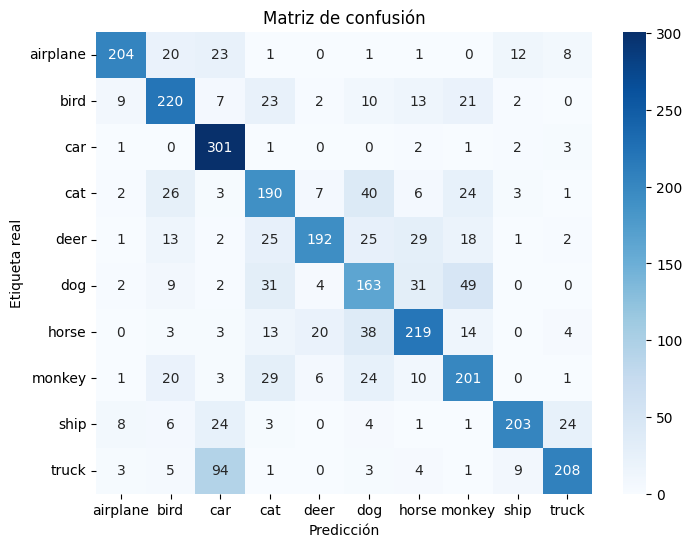

              precision    recall  f1-score   support

    airplane       0.88      0.76      0.81       270
        bird       0.68      0.72      0.70       307
         car       0.65      0.97      0.78       311
         cat       0.60      0.63      0.61       302
        deer       0.83      0.62      0.71       308
         dog       0.53      0.56      0.54       291
       horse       0.69      0.70      0.70       314
      monkey       0.61      0.68      0.64       295
        ship       0.88      0.74      0.80       274
       truck       0.83      0.63      0.72       328

    accuracy                           0.70      3000
   macro avg       0.72      0.70      0.70      3000
weighted avg       0.72      0.70      0.70      3000



In [62]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

@torch.no_grad()
def eval_report(model, loader, device="cuda", class_names=None):
    model.eval()
    y_true, y_pred = [], []

    for X, y in loader:
        X = X.to(device)
        logits = model(X)
        y_true.append(y.numpy())
        y_pred.append(logits.argmax(1).cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta real")
    plt.title("Matriz de confusión")
    plt.show()

    print(classification_report(y_true, y_pred, target_names=class_names))

classes = ['airplane','bird','car','cat','deer','dog','horse','monkey','ship','truck']
eval_report(model, test_loader, class_names=classes)

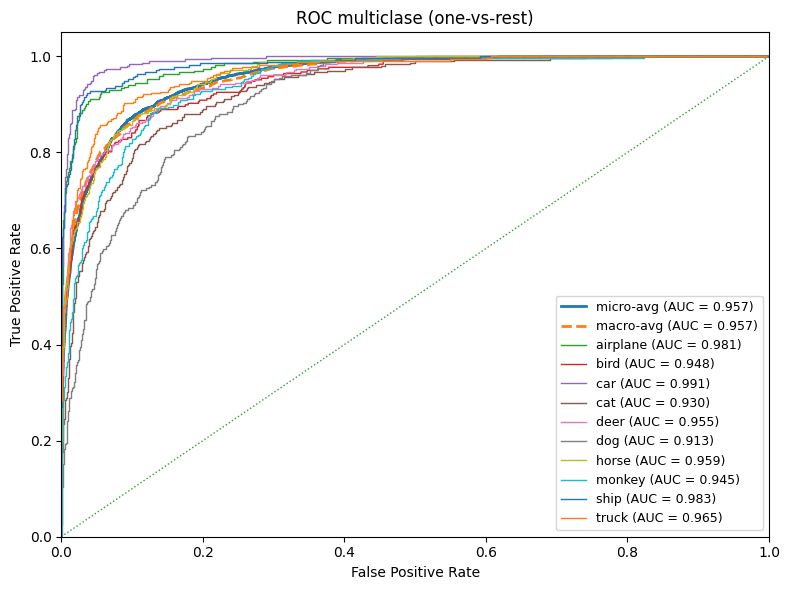

{0: np.float64(0.9810025776692443),
 1: np.float64(0.9484772319598042),
 2: np.float64(0.9909288646492379),
 3: np.float64(0.9302205705477199),
 4: np.float64(0.9548168213658556),
 5: np.float64(0.9133789747551436),
 6: np.float64(0.9592081612133688),
 7: np.float64(0.9450346188790376),
 8: np.float64(0.9827626371625493),
 9: np.float64(0.9652162899810135),
 'micro': np.float64(0.9572260555555555),
 'macro': np.float64(0.9572576586474174)}

In [63]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


@torch.no_grad()
def plot_multiclass_roc(
    model,
    loader,
    num_classes: int,
    device: str = "cuda",
    class_names=None,
    plot_per_class: bool = True):
    """
    Grafica ROC para problema multiclase (one-vs-rest) + micro y macro promedio.

    - model: nn.Module (en eval() devuelve logits [B,C])
    - loader: DataLoader de evaluación
    - num_classes: número de clases C
    - class_names: lista opcional de nombres (len=C)
    - plot_per_class: si True, dibuja curvas por clase; si False, solo micro/macro
    """
    device = torch.device(device)
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)                # [B,C]
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(y.cpu().numpy())

    y_true = np.concatenate(all_labels, axis=0)               # [N]
    y_score = np.concatenate(all_probs, axis=0)               # [N,C]

    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))  # [N,C]

    # 3) ROC por clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for c in range(num_classes):
        fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[c] for c in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             linestyle='-', linewidth=2,
             label=f"micro-avg (AUC = {roc_auc['micro']:.3f})")
    plt.plot(fpr["macro"], tpr["macro"],
             linestyle='--', linewidth=2,
             label=f"macro-avg (AUC = {roc_auc['macro']:.3f})")

    if plot_per_class:
        for c in range(num_classes):
            name = class_names[c] if class_names else f"Class {c}"
            plt.plot(fpr[c], tpr[c], linewidth=1,
                     label=f"{name} (AUC = {roc_auc[c]:.3f})")
    plt.plot([0, 1], [0, 1], linestyle=':', linewidth=1)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC multiclase (one-vs-rest)")
    plt.legend(loc="lower right", fontsize=9, ncol=1 if plot_per_class else 2)
    plt.tight_layout()
    plt.show()

    return roc_auc

classes = ['airplane','bird','car','cat','deer','dog','horse','monkey','ship','truck']
plot_multiclass_roc(
    inception_net,
    test_loader,
    num_classes=10,
    device="cuda",
    class_names=classes,
    plot_per_class=True)

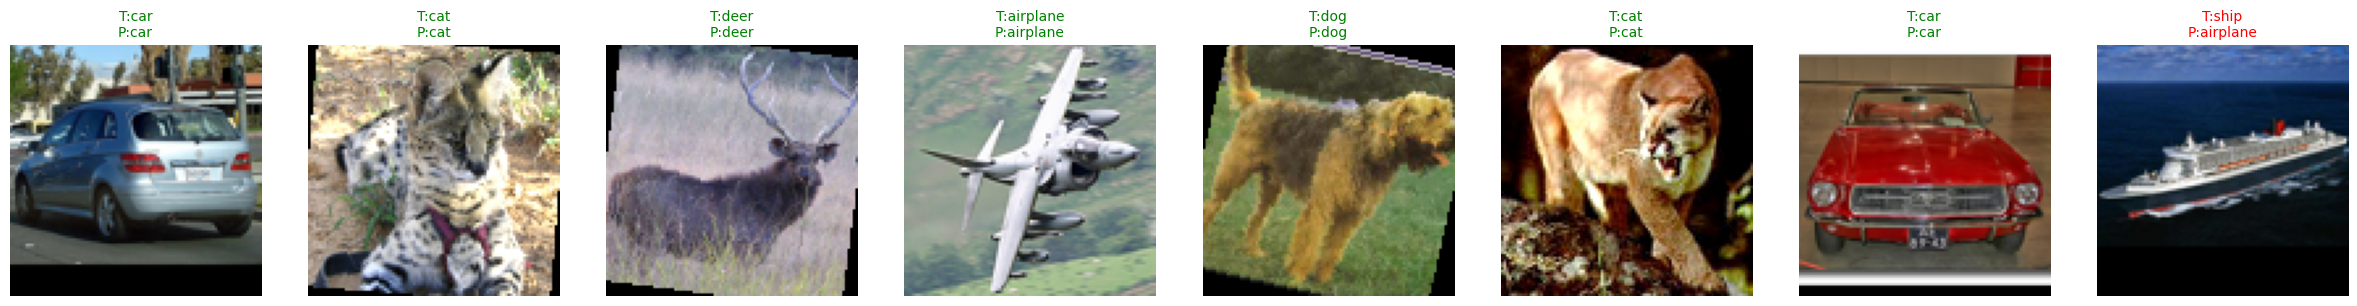

In [70]:
import random

@torch.no_grad()
def show_batch_predictions(model, loader, class_names, device="cuda", n=8):
    """
    Muestra un batch aleatorio de imágenes con etiquetas reales y predicciones del modelo.

    - model: red entrenada (GoogLeNet, ResNet, etc.)
    - loader: DataLoader (train o test)
    - class_names: lista con nombres de las clases
    - device: "cuda" o "cpu"
    - n: número de imágenes a mostrar
    """
    model.eval()
    device = torch.device(device)
    model.to(device)

    batch = random.choice(list(loader))
    X, y = batch
    X, y = X.to(device), y.to(device)

    # Forward
    logits = model(X)
    preds = logits.argmax(1)

    # Convertir imágenes para visualización
    X = X.cpu().permute(0, 2, 3, 1).numpy()

    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for i in range(n):
        img = X[i]
        img = (img - img.min()) / (img.max() - img.min())  # normaliza 0-1

        true_label = class_names[y[i].item()]
        pred_label = class_names[preds[i].item()]

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"T:{true_label}\nP:{pred_label}",
                          fontsize=10,
                          color=("green" if true_label==pred_label else "red"))

    plt.tight_layout()
    plt.show()

classes = ['airplane','bird','car','cat','deer','dog','horse','monkey','ship','truck']
show_batch_predictions(model, test_loader, class_names=classes, n=8)

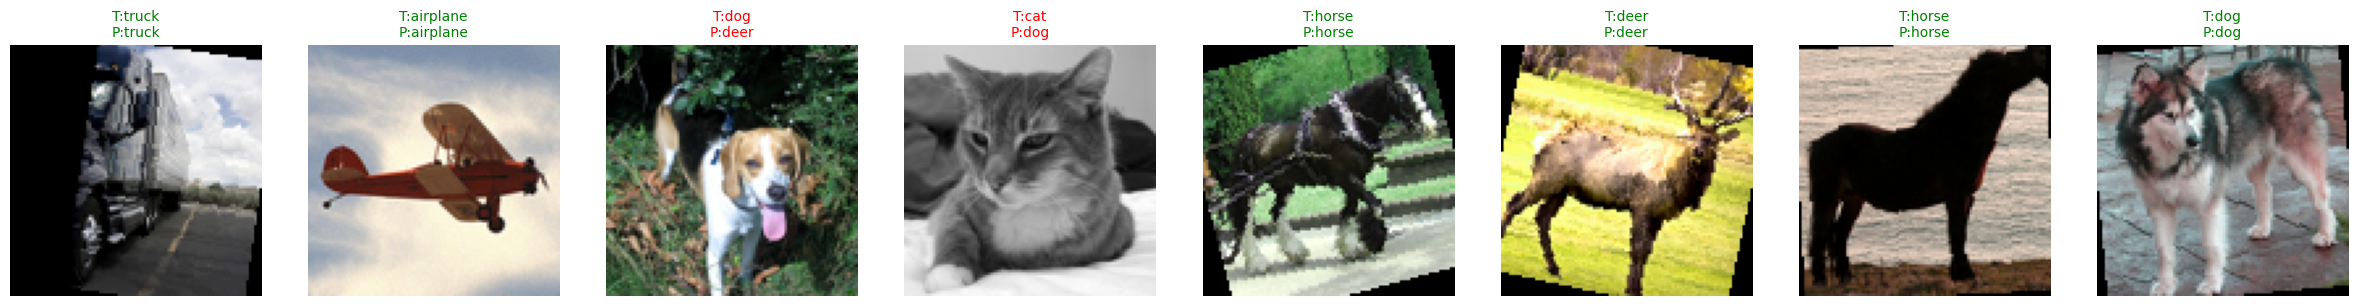

In [67]:
show_batch_predictions(model, test_loader, class_names=classes, n=8)

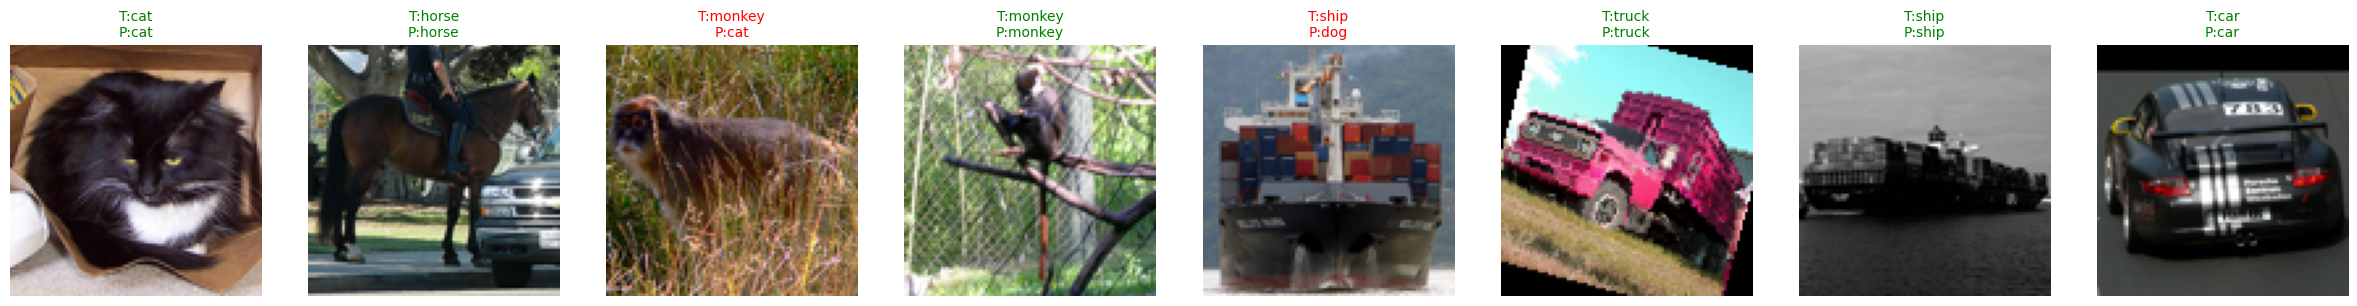

In [68]:
show_batch_predictions(model, test_loader, class_names=classes, n=8)

In [78]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

def _norm01(x):
    x = x.astype(np.float32)
    mn, mx = x.min(), x.max()
    if mx > mn:
        x = (x - mn) / (mx - mn)
    else:
        x = np.zeros_like(x)
    return x

@torch.no_grad()
def plot_inception_v1_block_activations(
    model,
    loader,
    block_attr='in3a',    # nombre del bloque: in3a, in3b, etc.
    n_filters=10,
    device='cuda'):
    """
    Muestra mapas de activación PRE (Conv2d) y POST (ConvBNReLU) para las ramas:
    - 1x1:        branch1
    - 3x3:        branch2_conv   (tras branch2_reduce)
    - 5x5:        branch3_conv   (tras branch3_reduce)
    - pool->1x1:  branch4_proj   (tras branch4_pool)

    Crea dos figuras; cada una es una rejilla 4 x n_filters (filas=ramas, cols=filtros).
    """
    model.eval()
    device = torch.device(device if (device == 'cpu' or torch.cuda.is_available()) else 'cpu')
    model.to(device)

    rand_idx = random.randrange(len(loader))
    for i, (Xb, yb) in enumerate(loader):
        if i == rand_idx:
            x = Xb[0:1].to(device)   # una imagen
            break

    try:
        block = getattr(model, block_attr)
    except AttributeError as e:
        raise ValueError(f"No existe '{block_attr}' en el modelo. Revisa el nombre del bloque.") from e

    branches_post = {
        '1x1': block.branch1,           # ConvBNReLU
        '3x3': block.branch2_conv,      # ConvBNReLU final (después de reduce)
        '5x5': block.branch3_conv,      # ConvBNReLU final
        'pool1x1': block.branch4_proj,  # ConvBNReLU después del MaxPool
    }
    branch_order = ['1x1', '3x3', '5x5', 'pool1x1']

    acts_pre = {}
    acts_post = {}
    hooks = []

    def make_pre_hook(name):
        def hook(module, inp, out):
            acts_pre[name] = out.detach().cpu()
        return hook

    def make_post_hook(name):
        def hook(module, inp, out):
            acts_post[name] = out.detach().cpu()
        return hook

    # Registrar hooks por rama
    for name in branch_order:
        mod_post = branches_post[name]          # ConvBNReLU (tiene .net = Sequential[Conv2d, BN, ReLU])
        if not hasattr(mod_post, 'net') or len(mod_post.net) < 3:
            raise RuntimeError(f"La rama '{name}' no parece ser ConvBNReLU(net[Conv, BN, ReLU]).")

        conv2d = mod_post.net[0]
        hooks.append(conv2d.register_forward_hook(make_pre_hook(name)))
        hooks.append(mod_post.register_forward_hook(make_post_hook(name)))

    _ = model(x)

    for h in hooks:
        h.remove()

    def _plot_mode(acts, title):
        fig, axes = plt.subplots(len(branch_order), n_filters,
                                 figsize=(n_filters*2.2, len(branch_order)*2.2))
        if len(branch_order) == 1 or n_filters == 1:
            axes = np.array(axes).reshape(len(branch_order), n_filters)

        for r, name in enumerate(branch_order):
            A = acts[name][0]
            C = A.shape[0]
            use = min(C, n_filters)
            for c in range(use):
                fmap = A[c].numpy()
                fmap = _norm01(fmap)
                axes[r, c].imshow(fmap, cmap='viridis', interpolation='nearest')
                axes[r, c].axis('off')
                if r == 0:
                    axes[r, c].set_title(f"F{c}", fontsize=9)

            for c in range(use, n_filters):
                axes[r, c].axis('off')

            axes[r, 0].set_ylabel(name, rotation=0, ha='right', va='center',
                                  fontsize=10, labelpad=25)

        plt.suptitle(f"{block_attr} — {title}", y=1.02, fontsize=12)
        plt.tight_layout()
        plt.show()


    _plot_mode(acts_pre, "PRE (salida Conv2d, antes de BN/ReLU)")
    _plot_mode(acts_post, "POST (salida ConvBNReLU, después de ReLU)")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d389c719260>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d389c719260>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

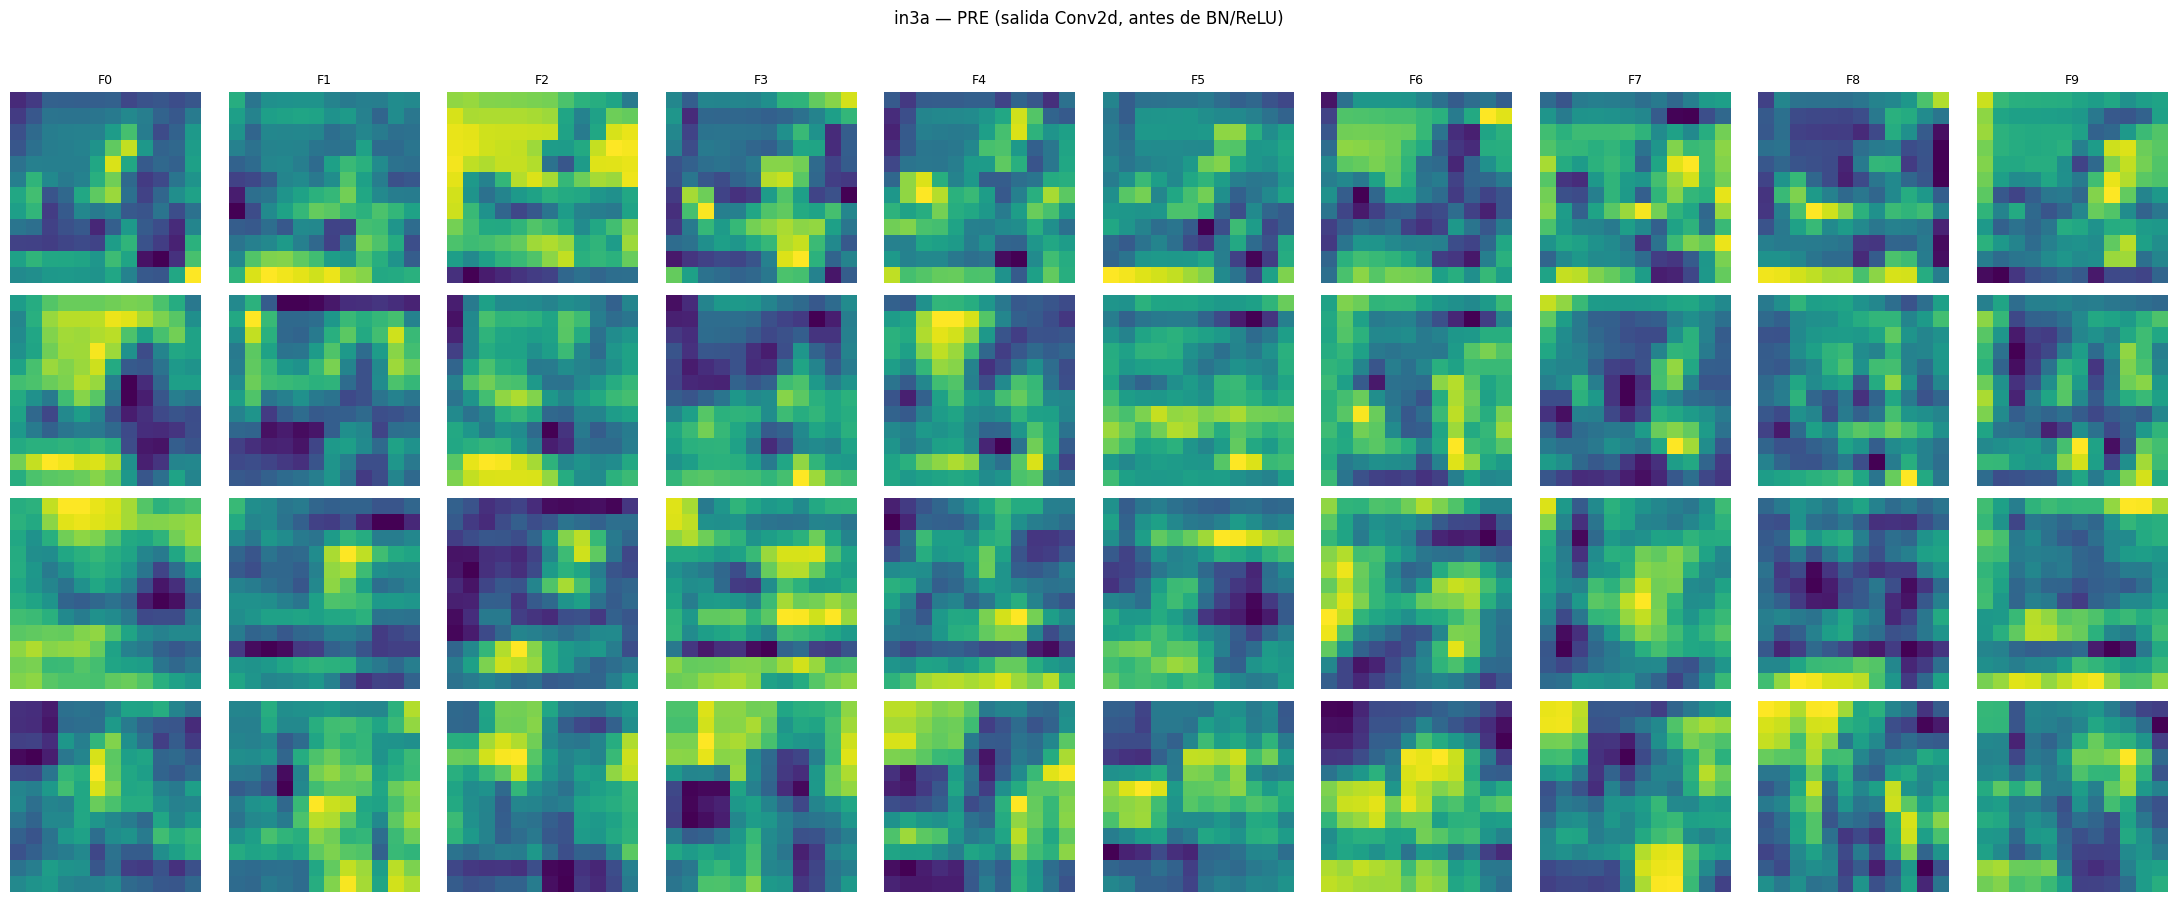

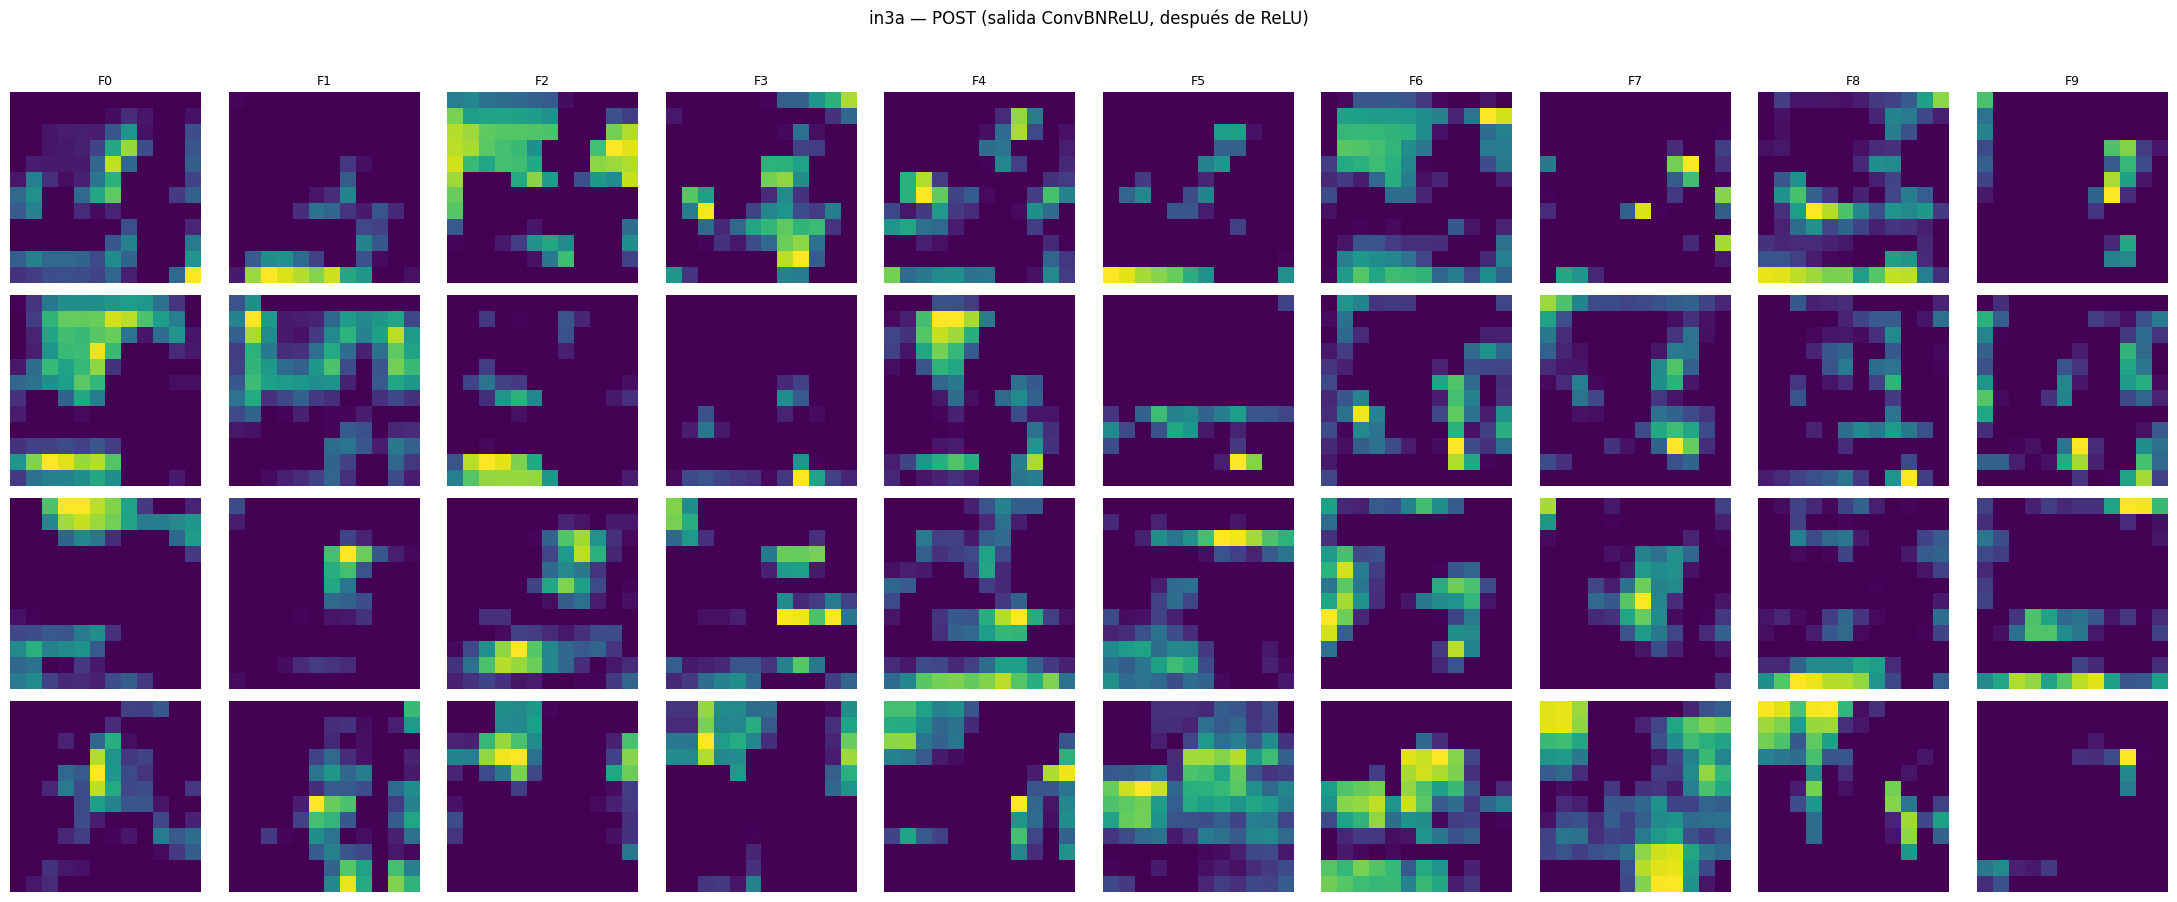

In [80]:
plot_inception_v1_block_activations(
    model,
    loader=train_loader,
    block_attr='in3a',
    n_filters=10,
    device='cuda')